In [33]:
import pandas as pd
from const import URL_DATABASE
from utils import create_engine
from utils import df_plot_history
from const import STOCK_NAME
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics
from matplotlib import pyplot as plt
import pickle
from utils import add_split_date

In [34]:
dbEngine = create_engine(URL_DATABASE)
connection = dbEngine.connect()

In [35]:
df = pd.read_sql_table('wig', connection)
df['Data'] = pd.to_datetime(df['Data'])
del df['index']
add_split_date(df)
df

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,year,month,day
0,1991-04-16,100.00,100.00,100.00,100.00,325.0,1991,4,16
1,1991-04-23,95.70,95.70,95.70,95.70,5905.0,1991,4,23
2,1991-04-30,93.50,93.50,93.50,93.50,7162.0,1991,4,30
3,1991-05-14,92.90,92.90,92.90,92.90,18300.0,1991,5,14
4,1991-05-21,95.50,95.50,95.50,95.50,14750.0,1991,5,21
...,...,...,...,...,...,...,...,...,...
7475,2022-12-28,1764.30,1776.98,1757.71,1767.88,10436182.0,2022,12,28
7476,2022-12-30,1797.53,1797.86,1786.56,1792.70,6736363.0,2022,12,30
7477,2022-12-30,1797.53,1797.86,1786.56,1792.70,6736363.0,2022,12,30
7478,2022-12-31,1797.53,1797.86,1786.56,1792.70,6736363.0,2022,12,31


In [36]:
x = df[['year', 'month', 'day', 'Otwarcie', 'Najwyzszy', 'Najnizszy', 'Wolumen','Zamkniecie']]
y = df['Zamkniecie'].shift(-1)
y = y[:-1]
x = x[:-1]
x.dtypes

year            int32
month           int32
day             int32
Otwarcie      float64
Najwyzszy     float64
Najnizszy     float64
Wolumen       float64
Zamkniecie    float64
dtype: object

In [37]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.7, shuffle=False, random_state=0)

In [38]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=1)
lasso.fit(train_x.values, train_y.values)

C:\Users\Mateusz\PycharmProjects\venv\BiS\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.262e+06, tolerance: 6.272e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=1)

In [39]:
print("lasso coefficient", lasso.coef_)
print("lasso intercept", lasso.intercept_)

lasso coefficient [-2.52998472e-01 -0.00000000e+00 -1.43674481e-01  2.52416505e-01
  3.74188095e-01  5.58642743e-02  8.33432535e-07  3.10711670e-01]
lasso intercept 510.92502650610436


In [40]:
lasso_confidence = lasso.score(test_x.values, test_y.values)
print("lasso confidence: ", lasso_confidence)

lasso confidence:  0.9927235904893632


In [41]:
predicted = lasso.predict(test_x.values)
print(test_x.head())

      year  month  day  Otwarcie  Najwyzszy  Najnizszy    Wolumen  Zamkniecie
2243  2002      2    1   1454.33    1470.07    1419.58  5979843.0     1427.72
2244  2002      2    4   1405.81    1415.13    1397.61  3981418.0     1401.43
2245  2002      2    5   1383.54    1385.94    1362.99  5992996.0     1371.98
2246  2002      2    6   1377.62    1386.12    1359.83  5959393.0     1382.04
2247  2002      2    7   1362.63    1375.90    1353.28  5659288.0     1362.59


In [42]:
dfr = pd.DataFrame({'Actual_Price': test_y, 'Predicted_Price': predicted})
dfr.head(10)

,Actual_Price,Predicted_Price
2243,1401.43,1449.354868
2244,1371.98,1405.057201
2245,1382.04,1378.961695
2246,1362.59,1380.312291
2247,1369.84,1365.901321
2248,1379.69,1364.019741
2249,1367.04,1382.769544
2250,1385.44,1378.454676
2251,1377.94,1373.939559
2252,1371.71,1385.171756


In [43]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(test_y, predicted))
print('Mean Squared Error (MSE) :', metrics.mean_squared_error(test_y, predicted))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(test_y, predicted)))

Mean Absolute Error (MAE): 28.6237700351147
Mean Squared Error (MSE) : 2177.1180568835975
Root Mean Squared Error (RMSE): 46.65959769311773


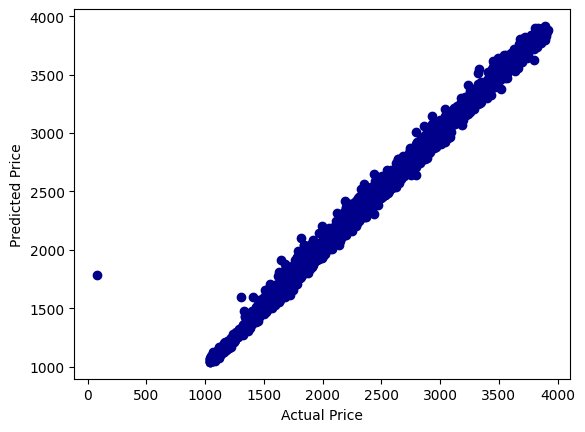

In [44]:
plt.scatter(dfr.Actual_Price, dfr.Predicted_Price, color='Darkblue')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


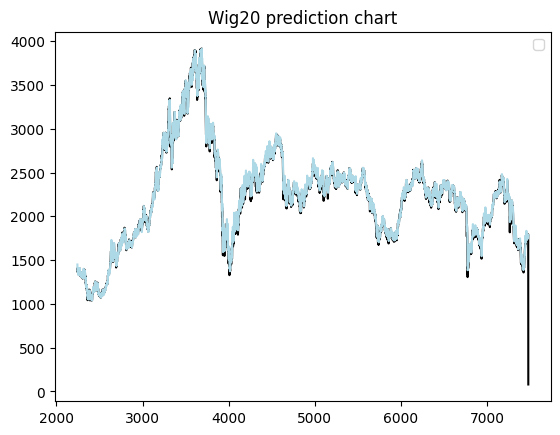

In [45]:
plt.plot(dfr.Actual_Price, color='black')
plt.plot(dfr.Predicted_Price, color='lightblue')
plt.title("Wig20 prediction chart")
plt.legend()

In [46]:
NNPickle = open('lasso', 'wb')
pickle.dump(lasso, NNPickle)
NNPickle.close()